In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

In [2]:
import survaeflow
import survaeflow.transform.bijection as bijection
import survaeflow.transform.surjection as surjection
from dataset.checkerboard import Checkerboard
from survaeflow.distribution.normal import Normal

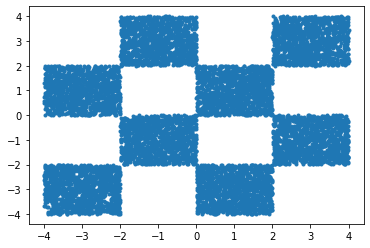

In [3]:
sample = Checkerboard.Sampler.sample(10000)
plt.plot(sample[:, 0], sample[:, 1], '.')

In [4]:
class Coupler(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(2)])
    def call(self, inputs):
        x = self.model(inputs)
        return tf.split(x, 2, axis=-1)

In [5]:
networks = [
    surjection.Abs(
        tf.keras.Sequential([  # inputs: [B, 2]
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(2)])),
    bijection.Scale([1/4, 1/4]),
    bijection.Logit()]

for _ in range(4):
    networks.extend([
        bijection.AffineCoupling(Coupler()),
        bijection.ActNorm(axis=-1),
        bijection.Conv1x1()])

model = survaeflow.Flow(
    prior=Normal(0.),
    networks=networks)

optim = tf.keras.optimizers.Adam(1e-3)

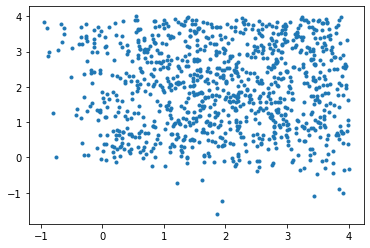

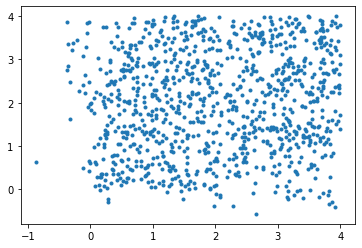

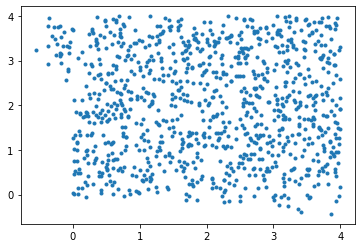

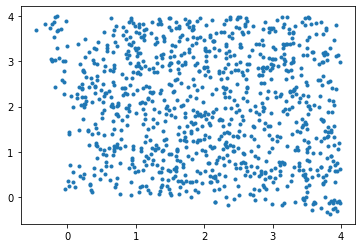

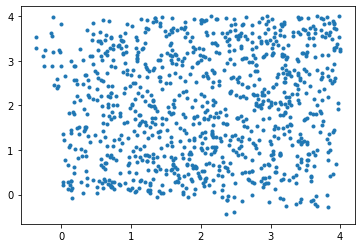

KeyboardInterrupt: 

In [6]:
dataset = Checkerboard(128000, 1280)
for _ in tqdm(range(10)):
    with tqdm(total=len(dataset), leave=False) as pbar:
        for x in dataset:
            with tf.GradientTape() as tape:
                _, log_prob = model(x)
                loss = -tf.reduce_mean(log_prob)
            grad = tape.gradient(loss, model.variables)
            optim.apply_gradients(zip(grad, model.variables))

            pbar.update()
            pbar.set_postfix({'loss': loss.numpy()})
    
    sample = model.sample([1000, 2]).numpy()
    plt.plot(sample[:, 0], sample[:, 1], '.')
    plt.show()